In [1]:
from pathlib import Path
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import itk
import torch
import numpy as np
from monai.losses import DiceLoss
from sklearn.metrics import classification_report
import pydicom
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from dotenv import load_dotenv
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImaged,
    EnsureChannelFirstD,
    SpatialResampleD,
    SpacingD,
    ResizeD,
    LoadImage,
    RandFlipD,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
    RandFlipd, DataStatsD,
)
from monai.data import Dataset, DataLoader
from monai.networks.nets import UNet
from monai.transforms import (
    LoadImaged,
    ScaleIntensityd,
    RandCropByPosNegLabeld,
    ToTensord,
)
from sklearn.model_selection import train_test_split
from monai.utils import set_determinism
import numpy as np
from monai.utils import first
load_dotenv()


True

In [2]:

def init_data_lists(base_data_path):
    mask_paths = []
    image_paths = []
    for dir in base_data_path.iterdir():
        if dir.is_dir():
            image_paths.append(dir / f"{dir.name}_prostate.nii.gz")
            mask_paths.append(dir / f"{dir.name}_segmentation.nii.gz")
    return image_paths, mask_paths

In [3]:
base_data_path = Path(
    os.getenv("DATA_PATH")
)
image_paths, mask_paths = init_data_lists(base_data_path)
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.2)
# Prepare data
data_dicts = [
    {"image": img_path, "label": mask_path}
    for img_path, mask_path in zip(train_image_paths, train_mask_paths)
]
train_files = data_dicts
RandFlipd_prob = .35
Spacing_dim = (1.5, 1.5, 3.0)
Size_dim = (96,96, 24)
ScaleIntensity_Image = (0, 255)
ScaleIntensity_Mask = (0, 1)
# Define transformations
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstD(keys=["image", "label"]), # Add channel to image and mask so 
        SpacingD(keys=["image", "label"], pixdim=Spacing_dim, mode=("bilinear", "nearest")), # Downsample to 2mm spacing
        ResizeD(keys=["image", "label"], spatial_size=Size_dim, mode=("bilinear", "nearest")), 
        DataStatsD(keys=["image", "label"]),
        ScaleIntensityd(keys=["image"], minv=ScaleIntensity_Image[0], maxv=ScaleIntensity_Image[1]),
        ScaleIntensityd(keys=["label"], minv=ScaleIntensity_Mask[0], maxv=ScaleIntensity_Mask[1]), # Coarse Segmentation combine all mask
        RandFlipd(keys=["image", "label"], prob=RandFlipd_prob, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=RandFlipd_prob, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=RandFlipd_prob, spatial_axis=2),
        ToTensord(keys=["image", "label"]),
    ]
)
validation_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstD(keys=["image", "label"]), # Add channel to image and mask so 
        SpacingD(keys=["image", "label"], pixdim=Spacing_dim, mode=("bilinear", "nearest")), # Downsample to 2mm spacing
        ResizeD(keys=["image", "label"], spatial_size=Size_dim, mode=("bilinear", "nearest")), 
        DataStatsD(keys=["image", "label"]),
        ScaleIntensityd(keys=["image"], minv=ScaleIntensity_Image[0], maxv=ScaleIntensity_Image[1]),
        ScaleIntensityd(keys=["label"], minv=ScaleIntensity_Mask[0], maxv=ScaleIntensity_Mask[1]), # Coarse Segmentation combine all mask
        ToTensord(keys=["image", "label"]),
    ]
)

# Create MONAI dataset and dataloader
train_ds = Dataset(data=data_dicts, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)


# Create U-Net model
# model = UNet(
#     dimensions=3,
#     in_channels=1,
#     out_channels=1,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
# )

/home/iejohnson/programing/Supervised_learning/DATA/SortedProstateData


monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256), # Number of features in each layer
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
loss = DiceLoss(sigmoid=True)
lr = 1e-3
opt = torch.optim.Adam(net.parameters(), lr)


In [5]:
# https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/unet_segmentation_3d_ignite.ipynb 
# TODO Continue with the tutorial adding the ignite training loop


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_image_histogram(image):
    plt.hist(image.ravel(), bins=256)
    plt.title('Image Histogram')
    plt.show()

def print_image_stats(image):
    print(f'Min: {np.min(image)}, Max: {np.max(image)}, Mean: {np.mean(image)}, Std: {np.std(image)}')

In [7]:
import itk

def load_image(image_path):
    image = itk.imread(image_path)
    image_array = itk.array_from_image(image)
    return image_array

def show_images(image_paths, mask_paths, num_images=5):
    fig, ax = plt.subplots(num_images, 2, figsize=(10, num_images * 5))
    for i in range(num_images):
        image = load_image(image_paths[i])
        mask = load_image(mask_paths[i])
        ax[i, 0].imshow(image[5], cmap='gray')
        ax[i, 0].set_title('Image')
        ax[i, 1].imshow(mask[5])
        ax[i, 1].set_title('Mask')
    plt.tight_layout()
    plt.show()

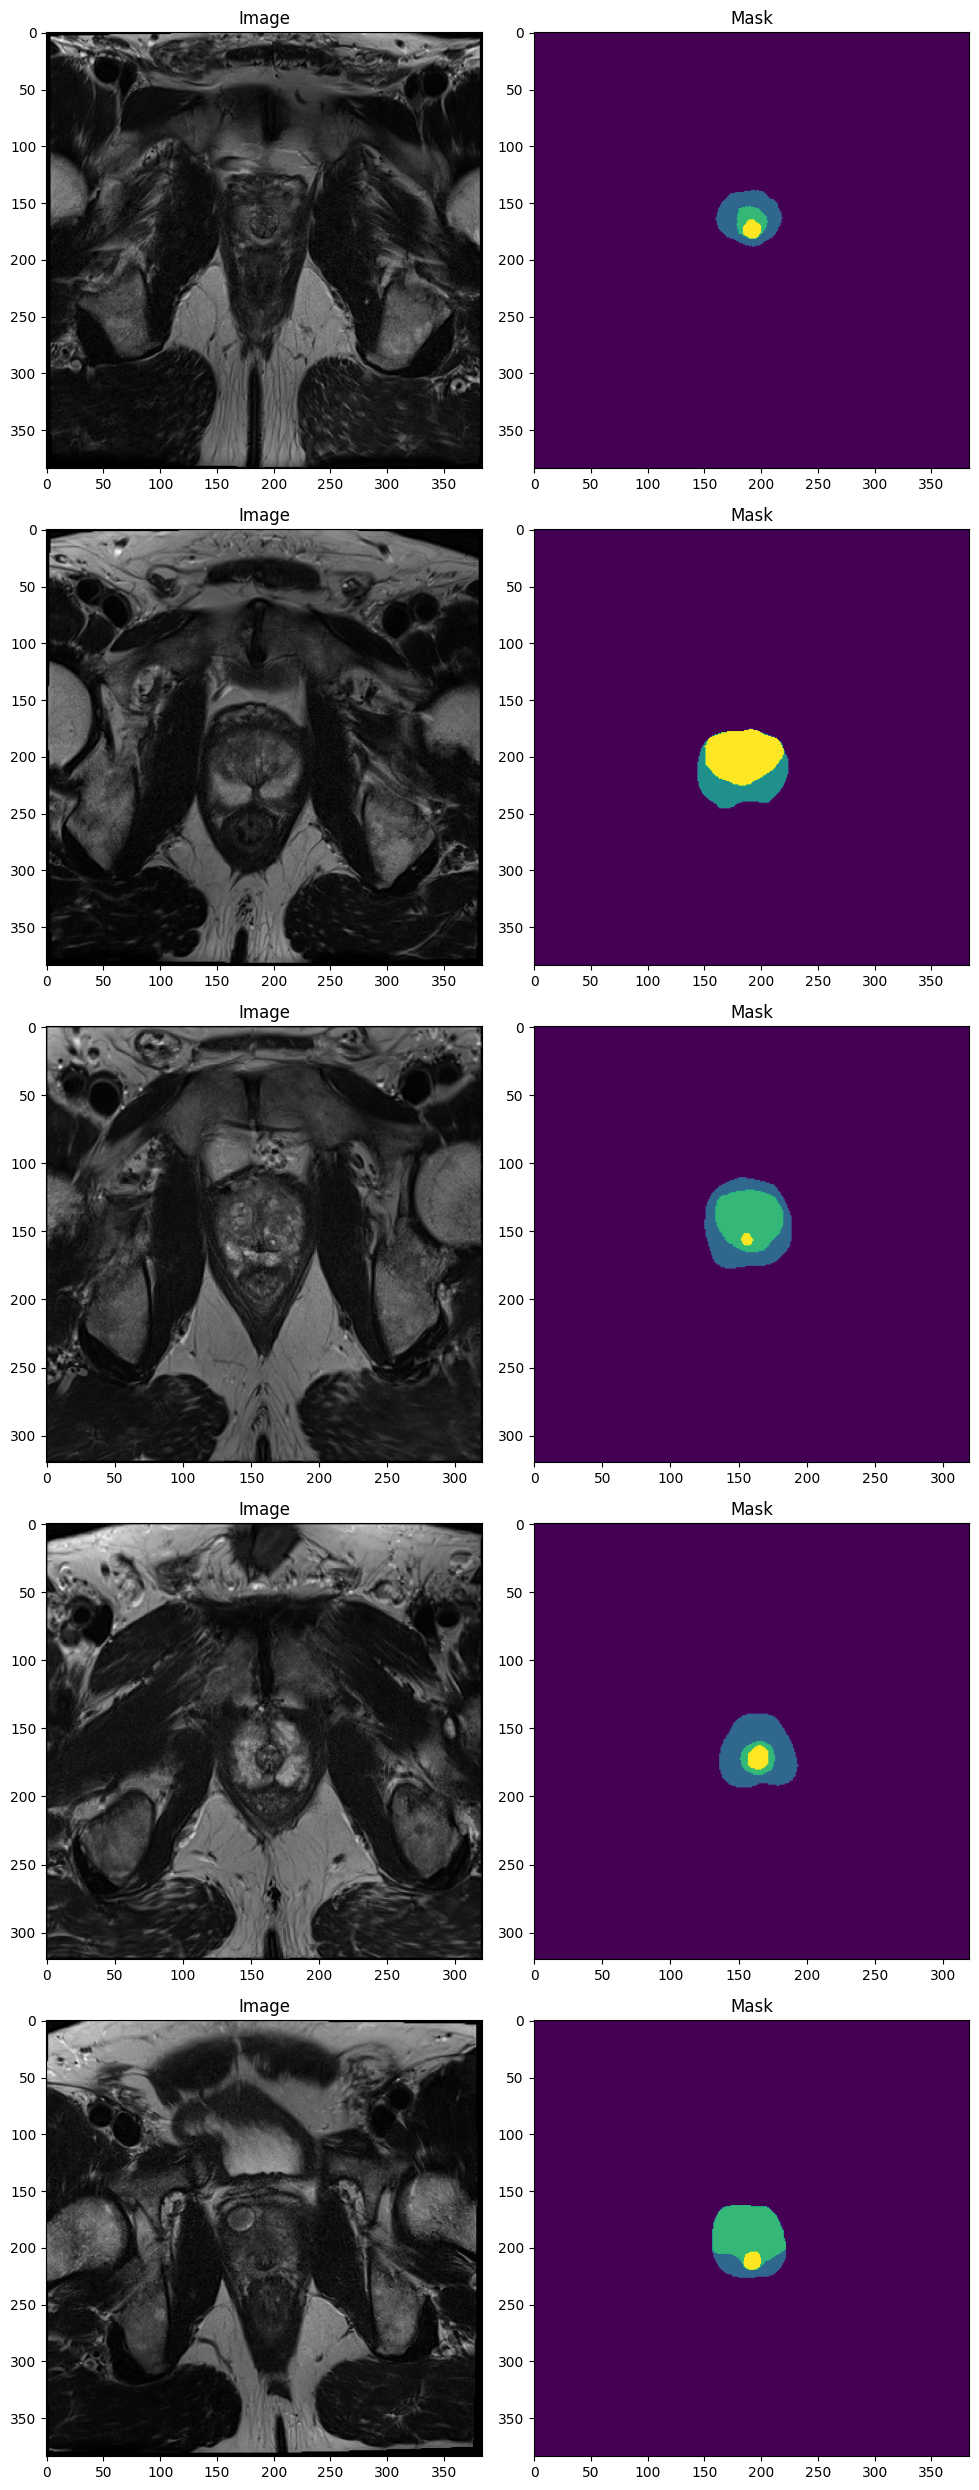

In [8]:
# Get a batch of images and masks
num_images = 5
explore_image_paths = image_paths[:num_images]
explore_mask_paths = mask_paths[:num_images]

# Show images

show_images(explore_image_paths, explore_mask_paths)

In [9]:
print(explore_mask_paths[0])
explore_mask = load_image(explore_mask_paths[0])
print_image_stats(explore_mask)
# plot_image_histogram(explore_mask)
print(np.unique(explore_mask)) 

/home/iejohnson/programing/Supervised_learning/DATA/SortedProstateData/ProstateX-0111/ProstateX-0111_segmentation.nii.gz
Min: 0.0, Max: 4.0, Mean: 0.03042406216263771, Std: 0.26503726840019226
[0. 1. 2. 3. 4.]


In [10]:
print(np.count_nonzero(explore_mask))

46644


In [11]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        ScaleIntensityd(keys=["image"]),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=[96, 96, 96],
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
